In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

from src.utils import create_regression
from src.models import FEO, EnsembleModel

## Example of model fitting with FEO

### Create a regressoin problem

In [2]:
# define a some samples for training
# m: number of samples
# n: number of features

m = 3
variables = 1
order = 5
include_bias = True
#n = 5
noise = 0.2

if variables == 1:
    x, x_order1 = create_regression(m, variables, order, include_bias=include_bias, return_non_poly=True)
else:
    x = create_regression(m, variables, order, include_bias=include_bias)
n = x.shape[1]
# x = np.random.random((m, n))*2-1
theta_true = np.random.random((n ,1))*2-1
y = x @ theta_true + np.random.normal(0, noise, (m, 1))


print(f"Info about problem: \nm: {m}, n: {n}, DOF: {max(0, n-m)}, rank: {np.linalg.matrix_rank(x)}")

Info about problem: 
m: 3, n: 6, DOF: 3, rank: 3


### Train and test model

In [5]:
temperature = 1e-13
fixed_u_star = True
u_star_mul = np.sum(y**2)
L2_regularized = False
alpha = 0.1

# Fit FEO
feo = FEO(temperature, L2_regularized=L2_regularized)
feo.fit(x, y, fixed_u_star=fixed_u_star, u_star_mul=u_star_mul)

# Fit other linear models for comparison
LS = linear_model.LinearRegression(fit_intercept=include_bias)
LS.fit(x, y)
lasso = linear_model.Lasso(alpha=alpha, fit_intercept=include_bias)
lasso.fit(x, y)
ridge = linear_model.Ridge(alpha=alpha, fit_intercept=include_bias)
ridge.fit(x, y)
elasticnet = linear_model.ElasticNet(alpha=alpha, fit_intercept=include_bias)
elasticnet.fit(x, y)

# Create an independent test set
if variables == 1:
    x_test, x_test_order1 = create_regression(100, variables, order, include_bias=include_bias, return_non_poly=True)
else:
    x_test = create_regression(100, variables, order, include_bias=include_bias)
y_test = x_test @ theta_true

# Perform inference for FEO
y_pred_FEO = feo.predict(x_test, 50)
thetas = feo._sample(50)
weighting = 'recip'
weighting_alpha = 3

# Ensemble models sampled from FEO with different methods
em1 = EnsembleModel(thetas, method='norm', weighting=weighting, alpha=weighting_alpha)
em2 = EnsembleModel(thetas, method='grad', weighting=weighting, alpha=weighting_alpha)
em3 = EnsembleModel(thetas, method='var', weighting=weighting, alpha=weighting_alpha)
theta_rand = np.random.normal(0, np.std(thetas, axis=0), size=thetas.shape)
em_random_norm = EnsembleModel(theta_rand, method='norm', weighting=weighting)
em_random_grad = EnsembleModel(theta_rand, method='grad', weighting=weighting)
em_random_var = EnsembleModel(theta_rand, method='var', weighting=weighting)

y_pred_FEO_ensemble1 = em1.predict(x_test)
y_pred_FEO_ensemble2 = em2.predict(x_test)
y_pred_FEO_ensemble3 = em3.predict(x_test)
y_pred_FEO_ensemble_rand1 = em_random_norm.predict(x_test)
y_pred_FEO_ensemble_rand2 = em_random_grad.predict(x_test)
y_pred_FEO_ensemble_rand3 = em_random_var.predict(x_test)

# Perform inference for all other trained linear models
y_pred_LS = LS.predict(x_test)
y_pred_L1 = lasso.predict(x_test)
y_pred_L2 = ridge.predict(x_test)
y_pred_L1L2 = elasticnet.predict(x_test)

MSE for LS prediction: 0.02486302708862632
MSE for L1 prediction: 0.11596999316853435
MSE for L2 prediction: 0.05784921801500596
MSE for L1 + L2 prediction: 0.08738259559326082
MSE for FEO prediction (ensemble by norm): 0.2525108079322648
MSE for FEO prediction (ensemble by grad): 0.2364068892680226
MSE for FEO prediction (ensemble by var): 0.38943904686907027


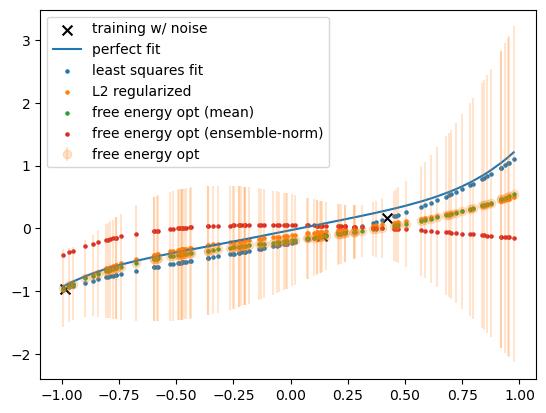

In [6]:
print(f"MSE for LS prediction: {mean_squared_error(y_test, y_pred_LS)}")
print(f"MSE for L1 prediction: {mean_squared_error(y_test, y_pred_L1)}")
print(f"MSE for L2 prediction: {mean_squared_error(y_test, y_pred_L2)}")
print(f"MSE for L1 + L2 prediction: {mean_squared_error(y_test, y_pred_L1L2)}")
print(f"MSE for FEO prediction (ensemble by norm): {mean_squared_error(y_test, y_pred_FEO_ensemble1)}")
print(f"MSE for FEO prediction (ensemble by grad): {mean_squared_error(y_test, y_pred_FEO_ensemble2)}")
print(f"MSE for FEO prediction (ensemble by var): {mean_squared_error(y_test, y_pred_FEO_ensemble3)}")


%matplotlib inline
if variables == 1:
    plt.scatter(x_order1, y, s=50, marker='x', color='black', label='training w/ noise')
    x_test_order1_ind = np.argsort(x_test_order1.reshape(-1))
    plt.plot(x_test_order1[x_test_order1_ind], x_test[x_test_order1_ind] @ theta_true, label='perfect fit')
    plt.scatter(x_test_order1, y_pred_LS, s=5, label="least squares fit")
    #plt.scatter(y_test, y_pred_L1, s=5, label='L1 regularized')
    plt.scatter(x_test_order1, y_pred_L2, s=5, label='L2 regularized')
    #plt.scatter(y_test, y_pred_L1L2, s=5, label='L1+L2 regularized')
    plt.scatter(x_test_order1, np.mean(y_pred_FEO, axis=1), s=5, label="free energy opt (mean)")
    plt.scatter(x_test_order1, y_pred_FEO_ensemble1, s=5, label="free energy opt (ensemble-norm)")
    plt.errorbar(x_test_order1, np.mean(y_pred_FEO, axis=1), yerr=np.std(y_pred_FEO, axis=1), fmt="o", alpha=0.2, label="free energy opt")
else:
    plt.scatter(y, x @ theta_true, s=10, marker='x', color='black', label='training')
    plt.plot(y_test, y_test, label='perfect fit')
    plt.scatter(y_test, y_pred_LS, s=5, label="least squares fit")
    #plt.scatter(y_test, y_pred_L1, s=5, label='L1 regularized')
    plt.scatter(y_test, y_pred_L2, s=5, label='L2 regularized')
    #plt.scatter(y_test, y_pred_L1L2, s=5, label='L1+L2 regularized')
    plt.scatter(y_test, np.mean(y_pred_FEO, axis=1), s=5, label="free energy opt")
    plt.scatter(y_test, y_pred_FEO_ensemble1, s=5, label="free energy opt (ensemble)")
    plt.errorbar(y_test, np.mean(y_pred_FEO, axis=1), yerr=np.std(y_pred_FEO, axis=1), fmt="o", alpha=0.2, label="free energy opt")
plt.legend()

## Perform replicates over randomly generated regression problems

In [7]:

losses = pd.DataFrame(columns=["m", "test_loss", "model"])

variables = 4
order = 2
include_bias = True
noise = 0.6
n = create_regression(m, variables, order, include_bias=include_bias).shape[1]

ms = np.unique((n*np.arange(0.2, 1, 0.2)).astype(int))
ms = ms[ms>=2]
#ms = [n]
temperatures = [0.01]#, 0.05, 0.1, 0.5, 1, 5, 10]
replicates = 100

for m in tqdm(ms):
    for i in range(replicates):
        x = create_regression(m, variables, order, include_bias=include_bias)
        theta_true = np.random.random((n ,1))*2-1
        gaussian_noise = np.random.normal(0, noise, (m, 1))
        y = x @ theta_true + gaussian_noise
        if m == n:
            remove = np.random.choice(m)
            #remove = np.argmax(gaussian_noise.reshape(-1))
            x = x[np.arange(m) != remove]
            y = y[np.arange(m) != remove]

        LS = linear_model.LinearRegression(fit_intercept=include_bias)
        LS.fit(x, y)
        ridge = linear_model.Ridge(alpha=alpha, fit_intercept=include_bias)
        ridge.fit(x, y)

        x_test = create_regression(100, variables, order, include_bias=include_bias)
        y_test = x_test @ theta_true
        y_pred_LS = LS.predict(x_test)
        y_pred_L2 = ridge.predict(x_test)

        feo = FEO(temperature, L2_regularized=False, w=alpha)
        feo.fit(x, y, fixed_u_star=True, u_star_mul=np.sum((x@theta_true - y)**2))#0.69)
        thetas = feo._sample(500)
        weighting = 'recip'
        weighting_alpha = max(2*max(n-np.abs(n-m)-2, 0), 1)
        
        em1 = EnsembleModel(thetas, method='norm', weighting=weighting, alpha=weighting_alpha)
        em2 = EnsembleModel(thetas, method='grad', weighting=weighting, alpha=weighting_alpha)
        em3 = EnsembleModel(thetas, method='var', weighting=weighting, alpha=weighting_alpha)

        y_pred_FEO_1 = em1.predict(x_test)
        y_pred_FEO_2 = em2.predict(x_test)
        y_pred_FEO_3 = em3.predict(x_test)


        losses = pd.concat([losses, pd.DataFrame({"m":m, "test_loss":[mean_squared_error(y_test, y_pred_LS)], "model":"LS"})], ignore_index=True)
        losses = pd.concat([losses, pd.DataFrame({"m":m, "test_loss":[mean_squared_error(y_test, y_pred_L2)], "model":"L2"})], ignore_index=True)
        losses = pd.concat([losses, pd.DataFrame({"m":m, "test_loss":[mean_squared_error(y_test, y_pred_FEO_1)], "model":f"FEO_norm"})], ignore_index=True)
        losses = pd.concat([losses, pd.DataFrame({"m":m, "test_loss":[mean_squared_error(y_test, y_pred_FEO_2)], "model":f"FEO_grad"})], ignore_index=True)
        losses = pd.concat([losses, pd.DataFrame({"m":m, "test_loss":[mean_squared_error(y_test, y_pred_FEO_3)], "model":f"FEO_var"})], ignore_index=True)
    


  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\zhoutx\AppData\Local\Temp\ipykernel_16372\837185199.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  losses = pd.concat([losses, pd.DataFrame({"m":m, "test_loss":[mean_squared_error(y_test, y_pred_LS)], "model":"LS"})], ignore_index=True)
100%|██████████| 4/4 [00:43<00:00, 10.88s/it]


### Note on ensembling method
* During inference, a set of models (n_models) are sampled with the same train loss
* These models are ensembled together with the EnsembleModel class
* The predictions of each of the n_models is weighted by a quality measure 
* For e.g. the inverse of the norm 1/norm(model weights) is a measure of quality, where smaller norm is assumed to be a simpler and thus better model

**Under-determined problem**
* When different amount of training data (m) is available relative to the number of features (n), we can change the weighting in the EnsembleModel accordingly
* When m = n, there is 0 degrees of freedom
* As m approaches n, we want to give a stronger weighting to the quality measure
* This is achieved using weighting_alpha term in the EnsembleModel. ie. 1/q**alpha where q is the quality measure (e.g. model norm)

Text(0, 0.5, 'weight to high quality models')

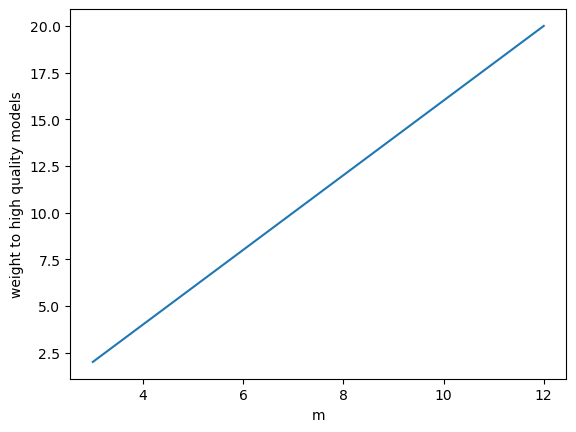

In [8]:
weighting_alpha = []
for m in ms:
    weighting_alpha.append(max(2*max(n-np.abs(n-m)-2, 0), 1))
plt.plot(ms, weighting_alpha)
plt.xlabel("m")
plt.ylabel("weight to high quality models")

In [9]:
losses_filt = losses[(losses['model'] != 'FEO_var') & (losses['model'] != 'FEO_grad')]
losses_filt

,m,test_loss,model
0,3,0.903491,LS
1,3,0.850536,L2
2,3,0.604885,FEO_norm
5,3,1.385840,LS
6,3,1.382891,L2
...,...,...,...
1991,12,1.741820,L2
1992,12,0.801045,FEO_norm
1995,12,5.805394,LS
1996,12,0.493695,L2


C:\Users\zhoutx\AppData\Local\Temp\ipykernel_16372\1795713460.py:2: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  plot = sns.pointplot(data=losses_filt, x='m', y='test_loss', hue='model', scale = 0.5, errorbar='se', dodge=True, ax=ax)


Text(0.5, 1.0, 'Test loss against size of training set (m) for 15-dimension linear regression')

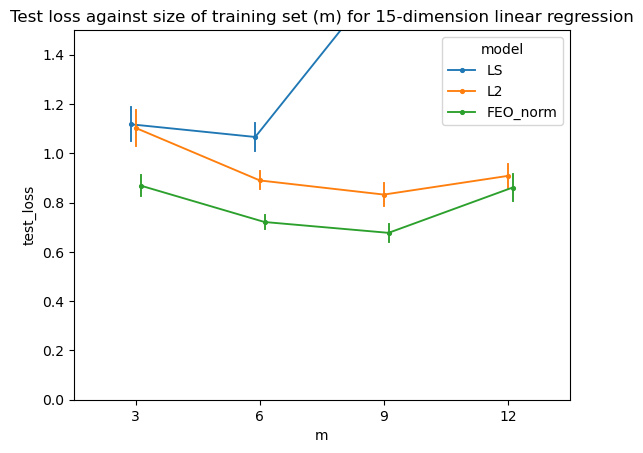

In [10]:
fig, ax = plt.subplots()
plot = sns.pointplot(data=losses_filt, x='m', y='test_loss', hue='model', scale = 0.5, errorbar='se', dodge=True, ax=ax)
ax.set_ylim(0, 1.5)
plt.title(f"Test loss against size of training set (m) for {n}-dimension linear regression")